In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('./data/divvy_daily.csv')
df = df[['date', 'rides']]
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y']

18:50:15 - cmdstanpy - INFO - Chain [1] start processing
18:50:15 - cmdstanpy - INFO - Chain [1] done processing


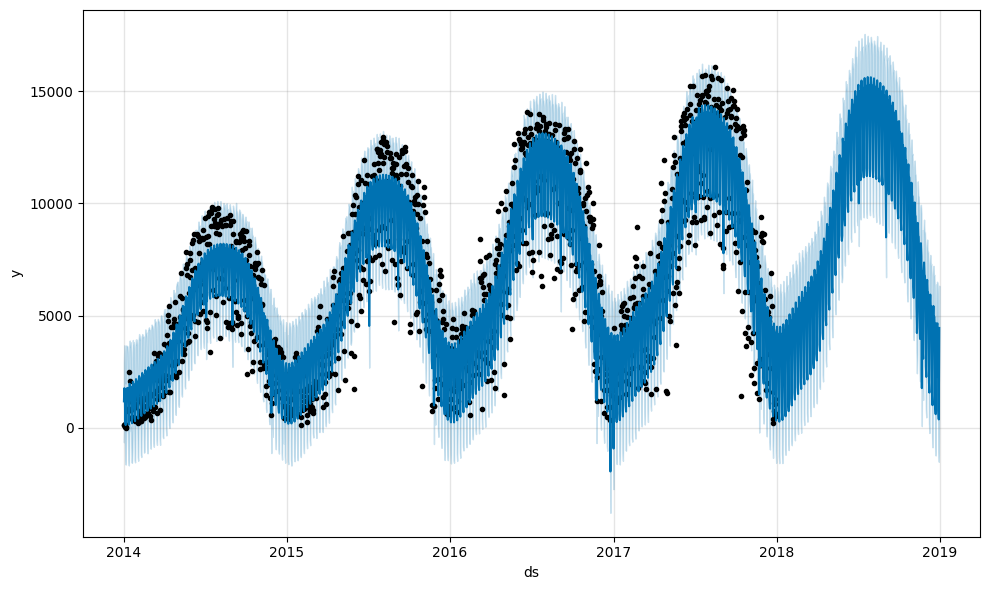

In [3]:
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=4)

# Adicionando um feriado
model.add_country_holidays(country_name='US')

model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

fig = model.plot(forecast)
plt.show()

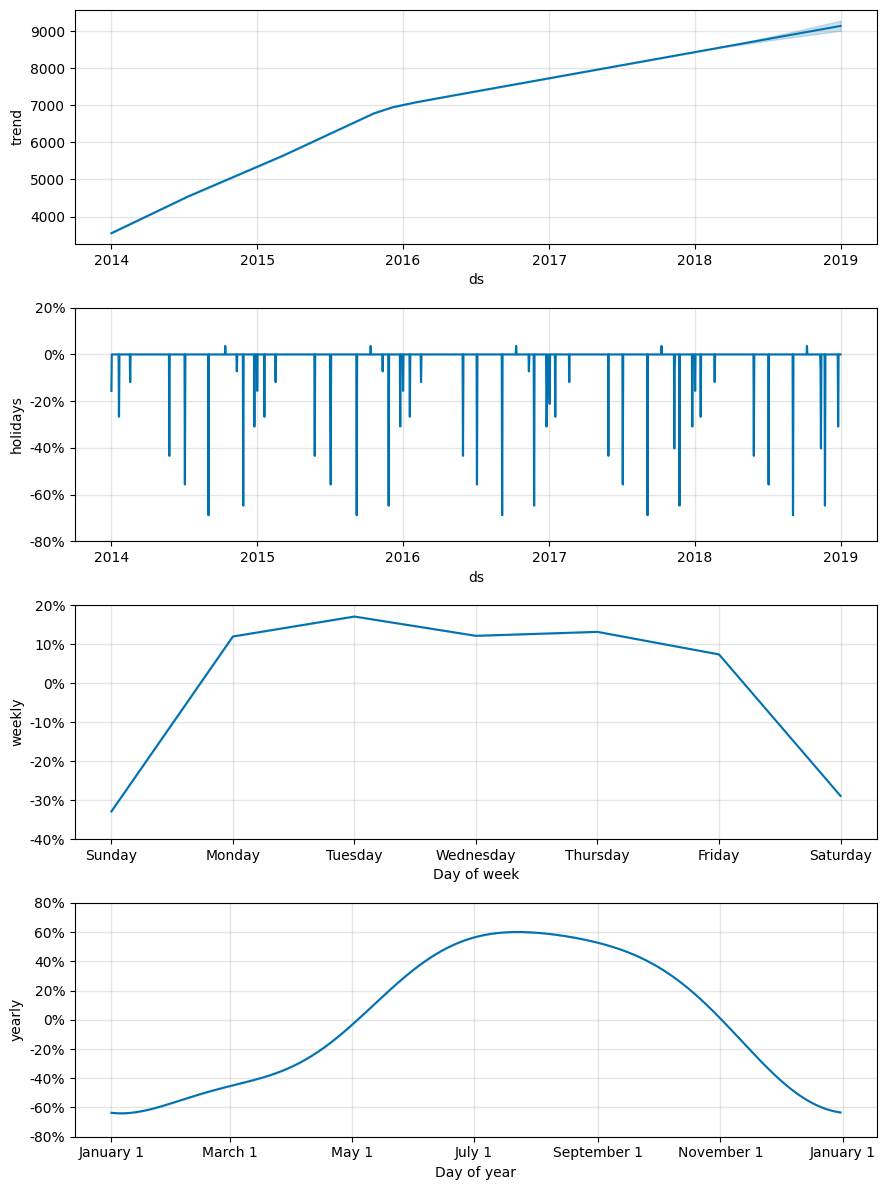

In [4]:
fig2 = model.plot_components(forecast)
plt.show()

In [5]:
# Identificando os feriados
model.train_holiday_names

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11      New Year's Day (Observed)
12        Veterans Day (Observed)
13    Independence Day (Observed)
dtype: object

In [6]:
# Construindo um DataFrame com o efeitos dos feriados

def  first_non_zeros(forecast, holiday):
    return forecast[forecast[holiday] != 0][holiday].values[0]

pd.DataFrame({'holiday': model.train_holiday_names,
              'effect': [first_non_zeros(forecast, holiday) for holiday in model.train_holiday_names],
              # 'effect_lower': [first_non_zeros(forecast, holiday+'_lower') for holiday in model.train_holiday_names],
              # 'effect_upper': [first_non_zeros(forecast, holiday+'_upper') for holiday in model.train_holiday_names],
             })

,holiday,effect
0,New Year's Day,-0.156036
1,Martin Luther King Jr. Day,-0.266482
2,Washington's Birthday,-0.118272
3,Memorial Day,-0.433747
4,Independence Day,-0.556240
5,Labor Day,-0.687647
6,Columbus Day,0.036225
7,Veterans Day,-0.072423
8,Thanksgiving,-0.646570
9,Christmas Day,-0.308413


### Adicionado feriados específico de estados

In [7]:
from prophet.make_holidays import make_holidays_df

In [8]:
year_list  = df['ds'].dt.year.unique().tolist()  # Results [2014, 2015, 2016, 2017]
year_list.append(year_list[-1] + 1) # Adicionando mais um ano na lista
holidays = make_holidays_df(year_list=year_list, country='US', state='IL')
holidays['ds'] = pd.to_datetime(holidays['ds'])
holidays.head()

,ds,holiday
0,2016-01-01,New Year's Day
1,2016-01-18,Martin Luther King Jr. Day
2,2016-02-12,Lincoln's Birthday
3,2016-02-15,Washington's Birthday
4,2016-03-07,Casimir Pulaski Day


In [9]:
# Adicionando os feriados ao modelo Prophet
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=4, holidays=holidays)

model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

18:50:17 - cmdstanpy - INFO - Chain [1] start processing
18:50:17 - cmdstanpy - INFO - Chain [1] done processing


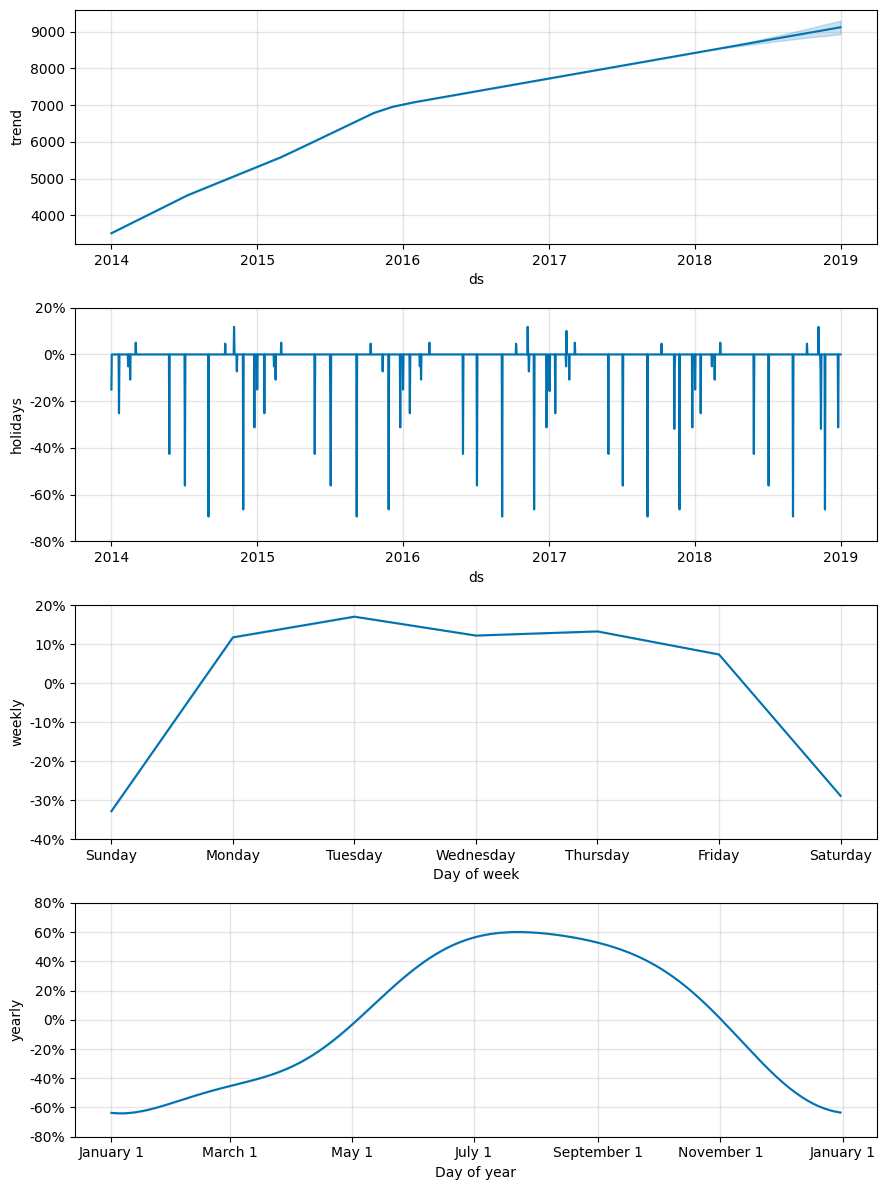

In [10]:
model.plot_components(forecast)
plt.show()

In [11]:
model.train_holiday_names

0                    New Year's Day
1        Martin Luther King Jr. Day
2                Lincoln's Birthday
3             Washington's Birthday
4               Casimir Pulaski Day
5                      Memorial Day
6                  Independence Day
7                         Labor Day
8                      Columbus Day
9                      Election Day
10                     Veterans Day
11                     Thanksgiving
12                    Christmas Day
13         Christmas Day (Observed)
14        New Year's Day (Observed)
15    Lincoln's Birthday (Observed)
16          Veterans Day (Observed)
17      Independence Day (Observed)
dtype: object

### Criando feriados customizados

Esses feriados podem ser datas tais como *Black Friday* e *Véspera de Natal*. Nessas data podem ter impactos na série temporal.

In [12]:
# Inserindo novos feriados no dataframe de holidays
# =================================================
holidays = make_holidays_df(year_list=year_list, country='US')

# Incluindo o black Friday
black_friday = pd.DataFrame({'holiday': 'Black Friday',
                             'ds': pd.to_datetime(
                                 [
                                     '2014-11-28',
                                     '2015-11-27',
                                     '2016-11-25',
                                     '2017-11-24',
                                     '2018-11-23',
                                 ])})

# Incluindo a Véspera de Natal
christmas_eve = pd.DataFrame({'holiday': 'Christmas Eve',
                              'ds': pd.to_datetime(
                                  [
                                      '2014-12-24',
                                      '2015-12-24',
                                      '2016-12-24',
                                      '2017-12-24',
                                      '2018-12-24',
                                   ])})

holidays = pd.concat([holidays, black_friday, christmas_eve]).sort_values('ds').reset_index(drop=True)
holidays

,ds,holiday
0,2014-01-01,New Year's Day
1,2014-01-20,Martin Luther King Jr. Day
2,2014-02-17,Washington's Birthday
3,2014-05-26,Memorial Day
4,2014-07-04,Independence Day
...,...,...
60,2018-11-12,Veterans Day (Observed)
61,2018-11-22,Thanksgiving
62,2018-11-23,Black Friday
63,2018-12-24,Christmas Eve


In [13]:
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=4, holidays=holidays)

model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Results with Black Friday and Christmas Eve
model.train_holiday_names

18:50:18 - cmdstanpy - INFO - Chain [1] start processing
18:50:18 - cmdstanpy - INFO - Chain [1] done processing


0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                    Black Friday
10                  Christmas Eve
11                  Christmas Day
12    Independence Day (Observed)
13       Christmas Day (Observed)
14      New Year's Day (Observed)
15        Veterans Day (Observed)
dtype: object

### Criando feriados de múltiplos dias

Alguns feriados podem ter um efeito de mais de 1 dia, assim usamos os argumento `window` para manipular isso.
Colocamos colunas adicionais chamadas de `lower_window` e `upper_window`.

No exemplo passado podemos usando os `Christmans Eve`, mas podemos usar o `lower_window=1` no `Christmas Day` que o efeito será o mesmo.

Em Chicago tem um evento que dura 5 dias em Julho, vamos modelar esse evento no prophet.

Vamos criar esse feriado como anteriormente, marcado o dia como o primeiro dia do evento e `upper_window=4` para indicar que haverão mais 4 dias a seguir.

In [15]:
holidays = make_holidays_df(year_list=year_list, country='US')
taste_of_chicago = pd.DataFrame({'holiday': 'Taste of Chicago',
                                 'ds': pd.to_datetime(['2014-07-09',
                                                       '2015-07-08',
                                                       '2016-07-06',
                                                       '2017-07-05',
                                                       '2018-07-11']),
                                 'lower_window': 0,
                                 'upper_window': 4})
holidays = pd.concat([holidays, taste_of_chicago]).sort_values('ds').reset_index(drop=True)

holidays.head(10)

,ds,holiday,lower_window,upper_window
0,2014-01-01,New Year's Day,NaN,NaN
1,2014-01-20,Martin Luther King Jr. Day,NaN,NaN
2,2014-02-17,Washington's Birthday,NaN,NaN
3,2014-05-26,Memorial Day,NaN,NaN
4,2014-07-04,Independence Day,NaN,NaN
5,2014-07-09,Taste of Chicago,0.0,4.0
6,2014-09-01,Labor Day,NaN,NaN
7,2014-10-13,Columbus Day,NaN,NaN
8,2014-11-11,Veterans Day,NaN,NaN
9,2014-11-27,Thanksgiving,NaN,NaN


In [17]:
# Agora ajustamos o modelos como anteriormente

model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=4, holidays=holidays)
model.fit(df)

future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)


# Para ver o efeito do feriado Taste of Chicago, podemos olhar:
print(forecast[forecast['ds'].isin(['2018-07-11',
                                    '2018-07-12',
                                    '2018-07-13',
                                    '2018-07-14',
                                    '2018-07-15',]
                                  )][['ds', 'Taste of Chicago']])

19:04:23 - cmdstanpy - INFO - Chain [1] start processing
19:04:23 - cmdstanpy - INFO - Chain [1] done processing


             ds  Taste of Chicago
1649 2018-07-11         -0.036176
1650 2018-07-12          0.020881
1651 2018-07-13          0.069573
1652 2018-07-14          0.015028
1653 2018-07-15          0.021692


Nós podemos ver que o primeiro dia de cada evento tem $3.6\%$ menos clientes do que teria se não tivesse o evento.

Já nos outros dias há um aumento no número de clientes, como por exemplo o útimo dia tendo $2.1\%$ mais do que o normal.

Como existem valores positivos e negativos baixos, pode ser que isso seja apenas o acaso.

https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html

Individual holidays can be plotted using the `plot_forecast_component` function (imported from `prophet.plot` in Python) like `plot_forecast_component(m, forecast, 'superbowl')` to plot just the superbowl holiday component.

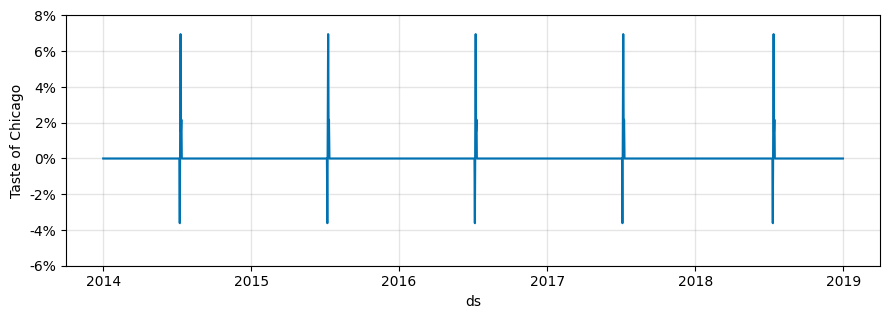

In [20]:
# Plotando apenas um componente
from prophet.plot import plot_forecast_component

fig3 = plot_forecast_component(model, forecast, 'Taste of Chicago', figsize=(10.5, 3.25))
plt.show()

### Regularizando os feriados

A regularização controla a flexibilidade do modelo e ajuda a generalizar para novos dados. Funciona de modo semelhante a regularização da sazonalidade estudada no capítulo 4.

pag 108